# PyTorch and CIFAR10 data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style='white', palette='pastel')

In [3]:
DATA_DIRS = {
    'all cores': os.path.join('csv', 'torchskeleton-noworker', '2021-11-19-11-57-49-all'),
    'cores 1, 3 - no hyper': os.path.join('csv', 'torchskeleton-noworker', '2021-11-19-13-00-46-core1,3-nohyper'),
    'core 1 - hyper': os.path.join('csv', 'torchskeleton-noworker', '2021-11-19-14-35-55-core1-hyper'),
    'core 1 - no hyper': os.path.join('csv', 'torchskeleton-noworker', '2021-11-19-15-31-58-core1-nohyper'),
}

In [4]:
dfs = {}

for name, data_dir in DATA_DIRS.items():
    run_filenames = (
        {int(file.name.split('-')[1][:-4]): file.name
         for file in sorted(list(os.scandir(data_dir)), key=lambda x: x.name)
         if file.is_file() and not file.name.startswith('.')}
    )

    df = pd.concat(
        [pd.concat({num: pd.read_csv(os.path.join(data_dir, filename), index_col='epoch')}, names=['run'])
         for num, filename in list(run_filenames.items())[1:]]
    )
    
    dfs[name] = df
    
df = pd.concat(dfs)
df.index.set_names(['setup', 'run', 'epoch'], inplace=True)

## Preview of the dataframe

The first run is removed as initialization causes its first epoch to take considerably longer.

In [5]:
df

duration  train acc  valid acc  \
setup             run epoch                                    
all cores         1   1      16.582162    0.43106     0.5119   
                      2      16.555712    0.62840     0.6946   
                      3      16.168410    0.70468     0.7541   
                      4      16.023914    0.73108     0.7602   
                      5      15.763814    0.75912     0.7938   
...                                ...        ...        ...   
core 1 - no hyper 4   21     14.294981    0.83068     0.8937   
                      22     14.253629    0.83888     0.8998   
                      23     14.378660    0.84916     0.9031   
                      24     14.316695    0.85630     0.9098   
                      25     14.316450    0.87306     0.9153   

                             package_0 energy  package_1 energy  \
setup             run epoch                                       
all cores         1   1           1668.434266       1616.578442   
                      2           1671.310236       1616.843517   
                      3           1636.032433       1582.593727   
                      4           1616.113599       1559.377478   
                      5           1587.017056       1559.337011   
...                                       ...               ...   
core 1 - no hyper 4   21           693.561213        803.905230   
                      22           699.683267        802.743245   
                      23           687.095715        806.949411   
                      24           686.515698        805.515882   
                      25           688.671028        805.371413   

                             dram_0 energy  dram_1 energy  \
setup             run epoch                                 
all cores         1   1         131.952004     139.179602   
                      2         132.017580     138.238576   
                      3         128.829841     134.508435   
                      4         127.685752     133.445651   
                      5         125.568461     131.285536   
...                                    ...            ...   
core 1 - no hyper 4   21         65.164780     121.056691   
                      22         70.594476     120.871392   
                      23         61.675937     121.874078   
                      24         62.246107     121.334615   
                      25         64.130960     121.244070   

                             nvidia_gpu_0 energy  nvidia_gpu_1 energy  \
setup             run epoch                                             
all cores         1   1                  957.115              400.626   
                      2                 1079.058              399.746   
                      3                  945.760              390.140   
                      4                 1088.017              386.104   
                      5                 1034.121              379.602   
...                                          ...                  ...   
core 1 - no hyper 4   21                1017.091              343.326   
                      22                1014.487              342.098   
                      23                 986.369              345.007   
                      24                1017.211              343.695   
                      25                1015.479              343.420   

                             package_0 power  package_1 power  dram_0 power  \
setup             run epoch                                                   
all cores         1   1           100.616206        97.489001      7.957467   
                      2           100.950673        97.660768      7.974141   
                      3           101.186974        97.881843      7.967997   
                      4           100.856355        97.315640      7.968449   
                      5           100.674685        98.918762      7.965614   
...                         

## Epoch duration

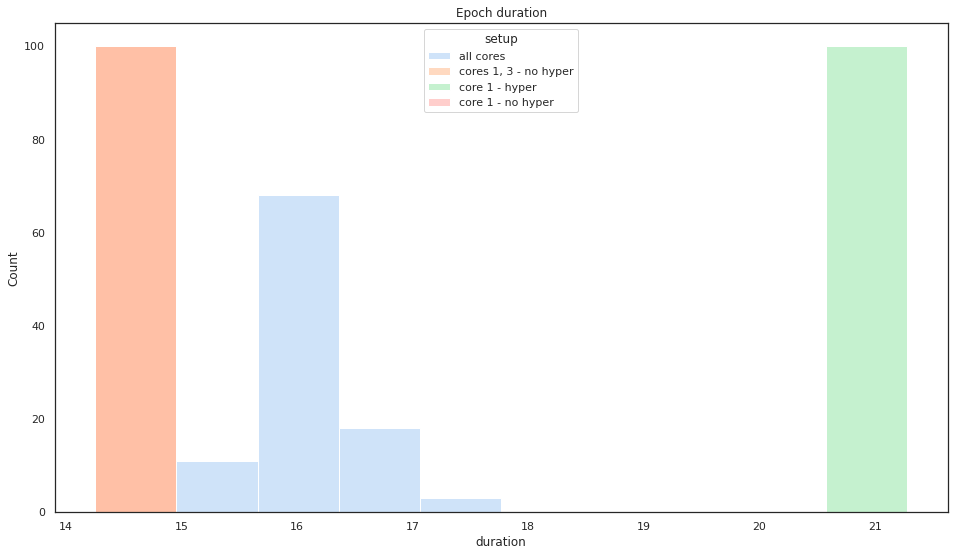

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(data=df, x='duration', hue='setup', kde=False, ax=ax)
ax.set_title('Epoch duration');

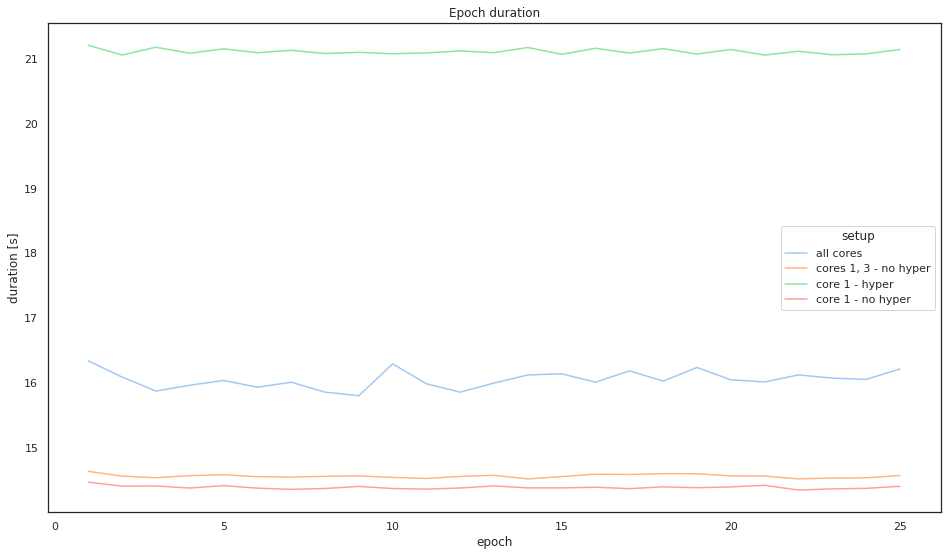

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='duration', hue='setup', ci=None, ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

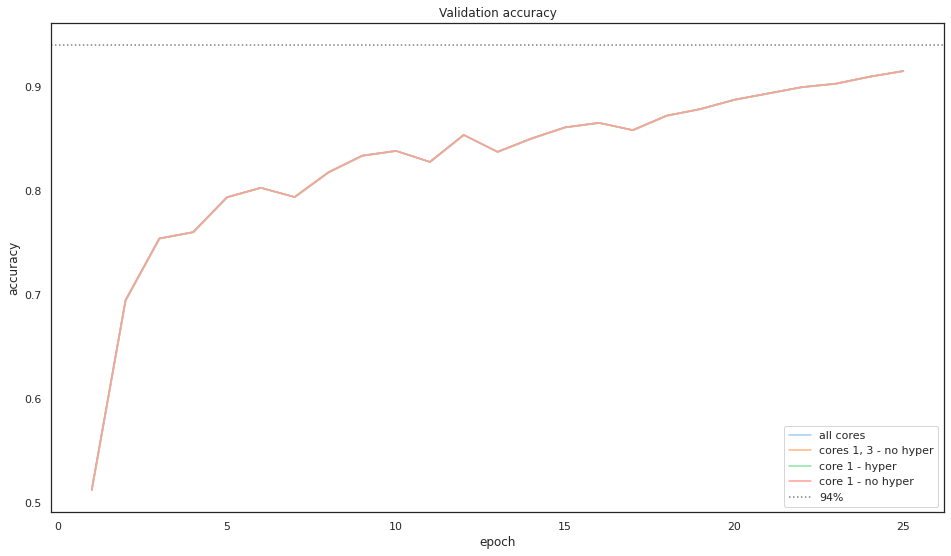

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='valid acc', hue='setup', ax=ax)
ax.axhline(0.94, linestyle=':', color='gray', label='94%')
ax.set_ylabel('accuracy')
ax.set_title('Validation accuracy')
ax.legend();

## Energy consumption

In [9]:
df_sum_energy_setup = df.filter(regex='energy').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_package_energy_setup = df.filter(regex='(?=.*package)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_gpu_energy_setup = df.filter(regex='(?=.*nvidia_gpu)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')

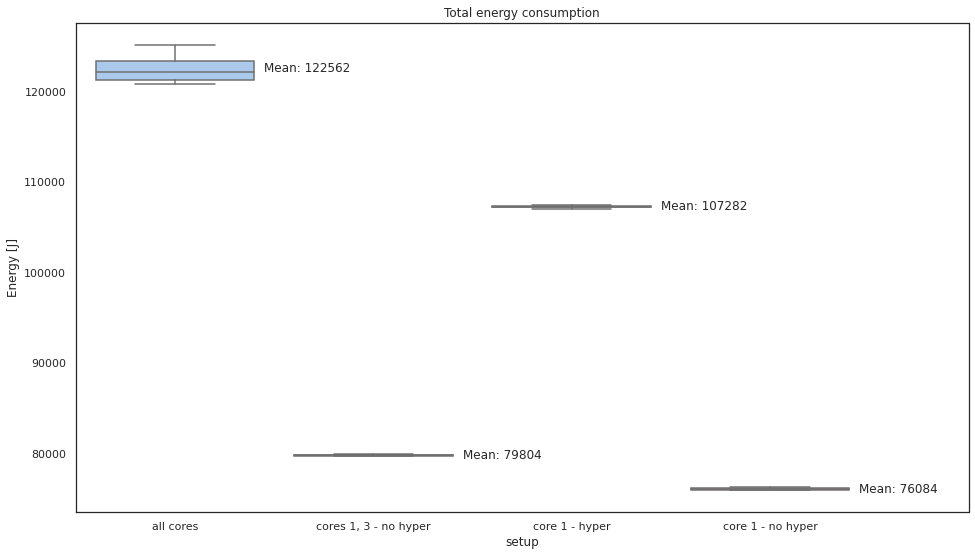

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_energy_setup, ax=ax)
ax.set_title('Total energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

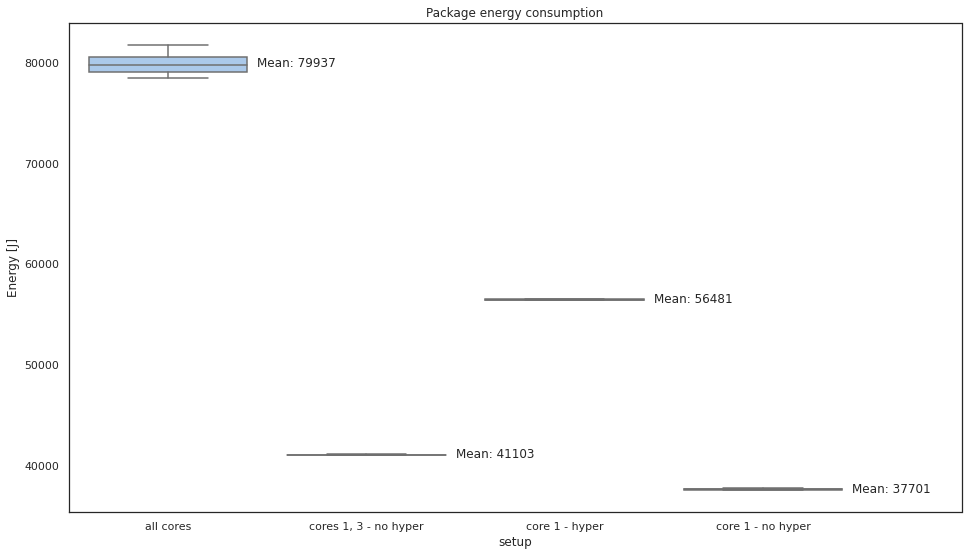

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_package_energy_setup, ax=ax)
ax.set_title('Package energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_package_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

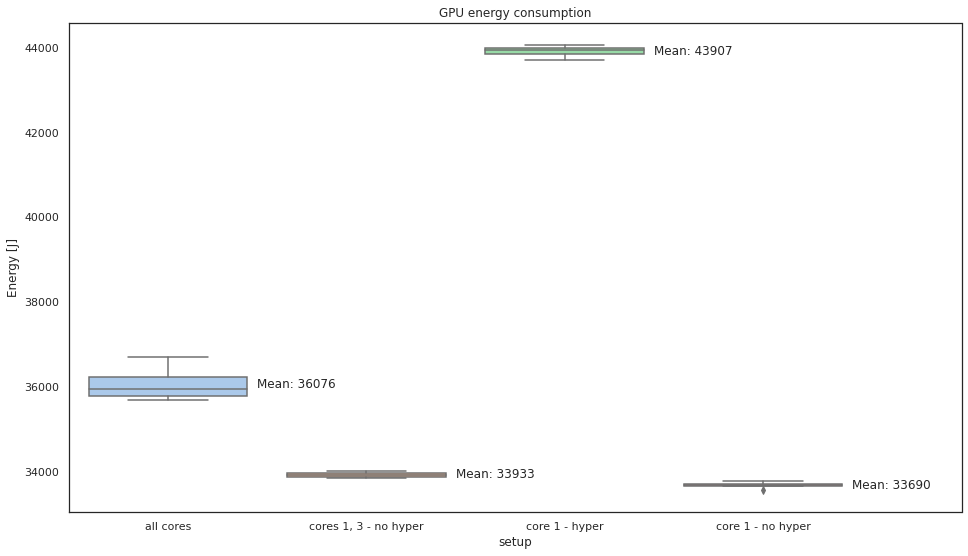

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_gpu_energy_setup, ax=ax)
ax.set_title('GPU energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_gpu_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [13]:
df_cum_energy_validacc_setup = df.groupby(level=['setup', 'epoch']).mean().reset_index().set_index(['setup', 'valid acc']).filter(like='energy').sum(axis=1).unstack(level='setup').cumsum().interpolate(method='index').dropna()

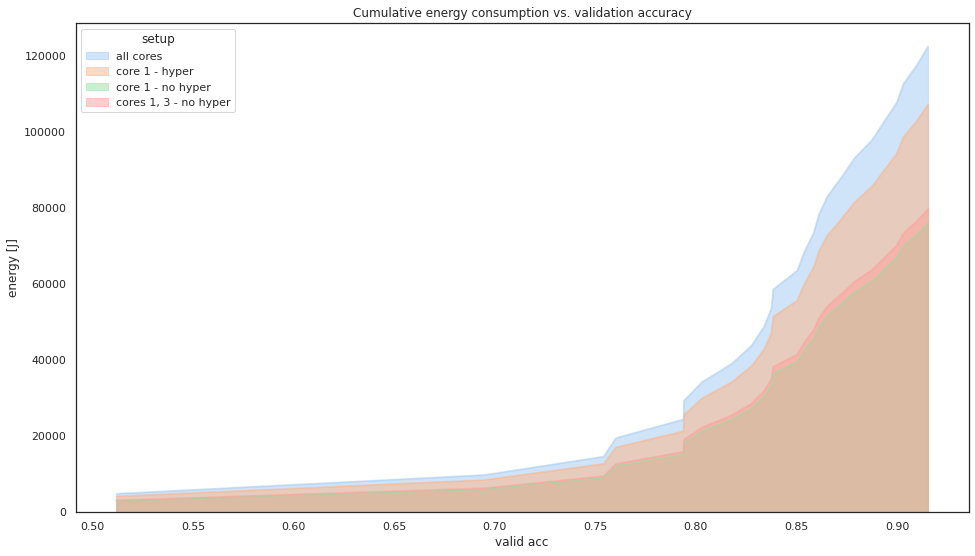

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc_setup.plot.area(ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy', stacked=False, ax=ax);

## Package power consumption

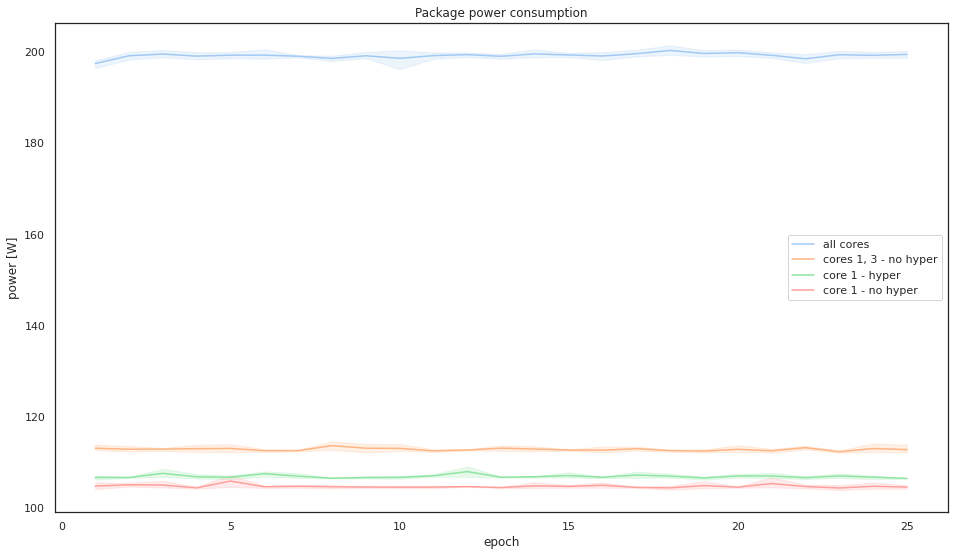

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
df['package power'] = df['package_0 power'] + df['package_1 power']
sns.lineplot(data=df, x='epoch', y='package power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package power consumption')
ax.legend();

## GPU power consumption

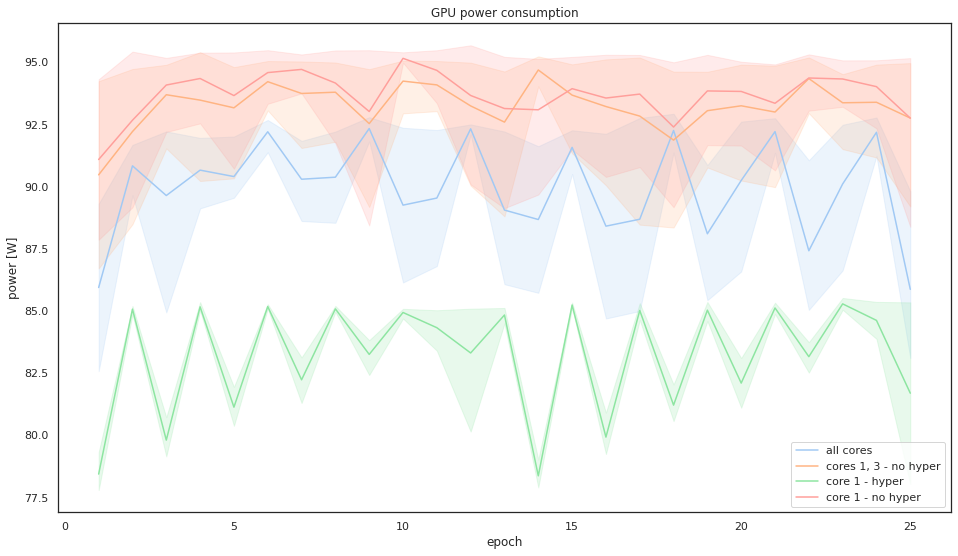

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
df['nvidia_gpu power'] = df['nvidia_gpu_0 power'] + df['nvidia_gpu_1 power']
sns.lineplot(data=df, x='epoch', y='nvidia_gpu power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();